In [1]:
from data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import torchvision
from tqdm.notebook import tqdm
from scipy.stats import spearmanr
import cv2

import captum
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)
print(torch.version.cuda)

cuda
12.4


In [2]:
image_size = (420, 420)

train_dataset = Dataset("data/train", size=image_size, save_in_ram=False)
test_dataset = Dataset("data/test", size=image_size, save_in_ram=False)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

Loading data from data/train


  0%|          | 0/880 [00:00<?, ?it/s]

Data loaded
Loading data from data/test


  0%|          | 0/220 [00:00<?, ?it/s]

Data loaded


In [3]:
model = torchvision.models.densenet121()
model.classifier = torch.nn.Linear(1024, 1)
model.load_state_dict(torch.load("densenet121_testloss8.7.pth"))
# model.load_state_dict(torch.load("densenet121_size224.pth"))
model.to(device)

loss_fn = nn.L1Loss()

Test target: tensor([50.], device='cuda:0')


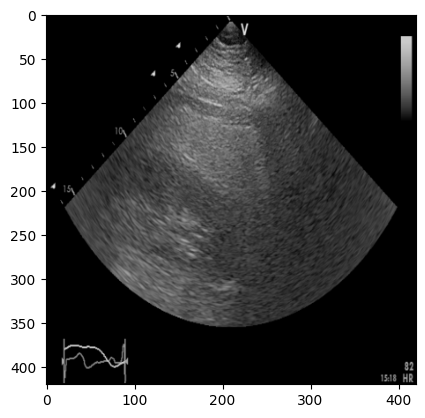

In [19]:
index = 89
test_img = test_dataset[index][0]
img_tensor = test_img.unsqueeze(0).to(device)
test_target = test_dataset[index][1]
print("Test target:", test_target)
plt.imshow(test_img.cpu().permute(1, 2, 0))

In [20]:
output = model(img_tensor)
pred_target = output.squeeze(0).long()
print("Model output:", output.item())

Model output: 48.27272033691406


In [21]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

In [22]:
# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(
    img_tensor, 
    target=None, 
    n_steps=500,
    internal_batch_size=10)

In [23]:
# Visualize
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

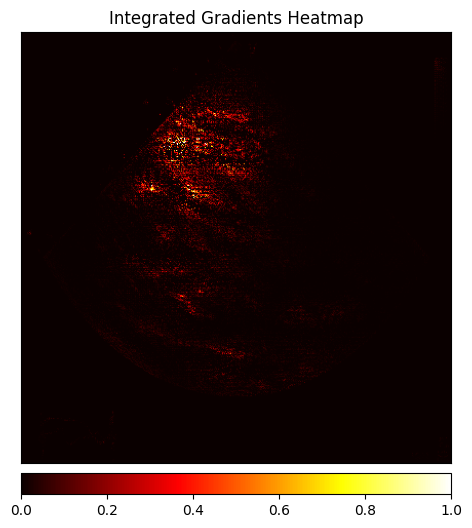

In [24]:
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                             np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                             method='heat_map',
                             cmap="hot",
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients Heatmap')

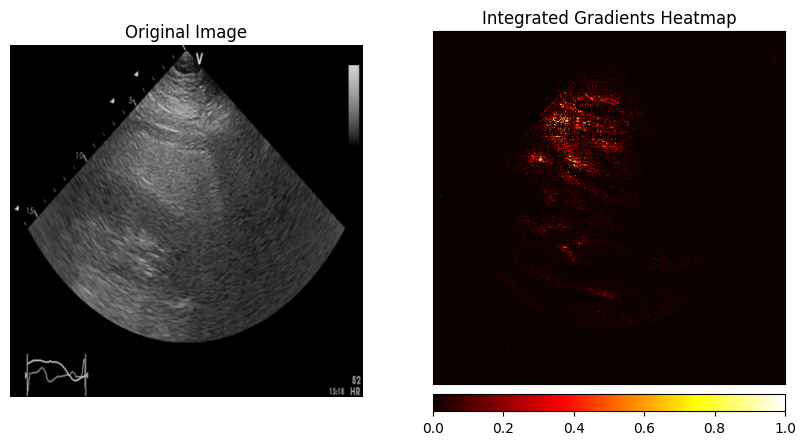

(<Figure size 1000x500 with 3 Axes>,
 <Axes: title={'center': 'Integrated Gradients Heatmap'}>)

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axs[0].imshow(np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0)))
axs[0].axis('off')
axs[0].set_title("Original Image")

# Attribution heatmap
viz.visualize_image_attr(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    method='heat_map',
    cmap='hot',  # or custom colormap
    show_colorbar=True,
    sign='positive',
    plt_fig_axis=(fig, axs[1]),
    title="Integrated Gradients Heatmap"
)

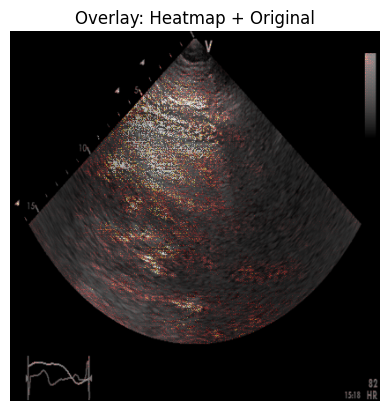

In [31]:
# Convert attribution to numpy image
attr = attributions_ig.squeeze().cpu().detach().numpy()
attr = np.sum(attr, axis=0)  # Convert [3, H, W] to [H, W]
# attr = np.maximum(attr, 0)
# attr /= attr.max()  # Normalize to [0,1]
attr *= 2  # boost attribution intensity
attr = np.clip(attr, 0, 1)  # keep in [0,1]

# Resize and convert to heatmap
# heatmap = cv2.applyColorMap(np.uint8(255 * attr), cv2.COLORMAP_JET)
heatmap = cv2.applyColorMap(np.uint8(255 * attr), cv2.COLORMAP_HOT)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Prepare original image
original = np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0))
original = (original - original.min()) / (original.max() - original.min())  # Normalize
original = np.uint8(255 * original)

# Blend heatmap with original image
overlay = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

# Show overlay
plt.imshow(overlay)
plt.title("Overlay: Heatmap + Original")
plt.axis('off')
plt.show()